<a href="https://colab.research.google.com/github/elifsare/Realtime-Emotion-Recognition/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
!ls

Mounted at /content/drive
drive  sample_data


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elifsare","key":"65fe5c557a5858f538b76c194afd0b9a"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

100% 284M/285M [00:09<00:00, 36.2MB/s]
100% 285M/285M [00:10<00:00, 29.9MB/s]


In [5]:
!mkdir face_dataset
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip -d face_dataset

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: face_dataset/example_submission.csv  
  inflating: face_dataset/fer2013.tar.gz  
  inflating: face_dataset/icml_face_data.csv  
  inflating: face_dataset/test.csv   
  inflating: face_dataset/train.csv  


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler

from keras.utils import np_utils

In [7]:
train_df = pd.read_csv('/content/face_dataset/train.csv')
train_df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [8]:
train_df.shape

(28709, 2)

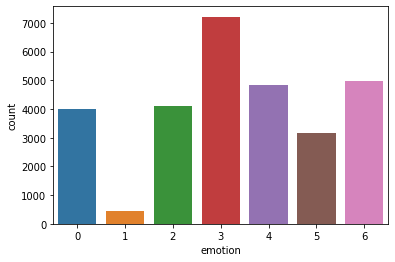

In [9]:
sns.countplot(x = 'emotion', data = train_df)
plt.show()

In [10]:
(train_df.emotion.value_counts() / len(train_df)).to_frame().sort_index().T

,0,1,2,3,4,5,6
emotion,0.139155,0.015187,0.142708,0.251315,0.16824,0.110453,0.172942


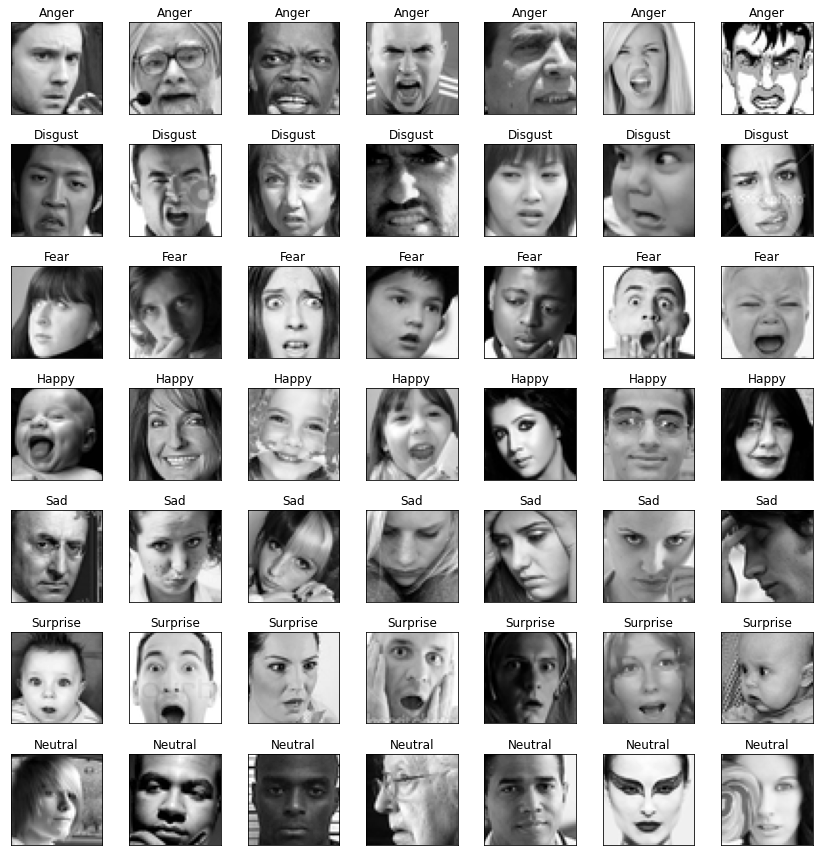

In [11]:
emotion_label = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
fig = plt.figure(1, (12,12))
k=0

for label in sorted(train_df.emotion.unique()):
    for j in range(7):
        px = train_df[train_df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48,48).astype('float32')
        
        k += 1
        ax = plt.subplot(7,7,k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label[label])
        plt.tight_layout()

In [12]:
pixels = train_df.pixels
labels = train_df.emotion

print('Pixel Shape: ', pixels.shape)
print('Label Shape: ', labels.shape)

Pixel Shape:  (28709,)
Label Shape:  (28709,)


In [13]:
# Converting Strings to Arrays
def preprocess(pixel_data):
    images = []
    for i in range(len(pixel_data)):
        img = np.fromstring(pixel_data[i], dtype='int', sep=' ')
        img = img.reshape(48,48,1)
        images.append(img)
    X = np.array(images)
    
    return X

In [14]:
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size = 0.2, random_state = 1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(22967,) (5742,) (22967,) (5742,)


In [15]:
oversampler = RandomOverSampler(sampling_strategy = 'minority')
X_over, y_over = oversampler.fit_resample(X_train.values.reshape(-1, 1), y_train)

X_over_series = pd.Series(X_over.flatten())

Xos_train = preprocess(X_over_series)

yos_train = y_over
y_over.values.reshape(yos_train.shape[0],1)

Xos_test = preprocess(X_test.values)

print(Xos_train.shape, yos_train.shape, Xos_test.shape)

(28346, 48, 48, 1) (28346,) (5742, 48, 48, 1)


In [16]:
np.random.seed(1)
tf.random.set_seed(1)
num_classes = 7

model = Sequential([
     #1st
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(48,48,1)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),
    
    #2nd
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),
    
    #3rd
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),
    
    #4th
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),
    
    #5th
    Conv2D(512, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),
    Flatten(),
    
    #Dense
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [17]:
# early stopping to avoid overfitting

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_learningrate = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, reduce_learningrate]

In [18]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [19]:
y_train = np_utils.to_categorical(yos_train, num_classes=7)
y_test = np_utils.to_categorical(y_test, num_classes=7)

In [20]:
%%time

h0 = model.fit(
    Xos_train, y_train,
    steps_per_epoch=len(Xos_train) / 64,
    epochs=30,
    verbose=1,
    callbacks=callbacks,
    validation_data=(Xos_test,y_test),
    validation_steps=len(Xos_test) / 64
)

Epoch 1/30
442/442 [==============================] - 47s 80ms/step - loss: 2.4116 - accuracy: 0.1629 - val_loss: 2.0987 - val_accuracy: 0.1139 - lr: 1.0000e-04
Epoch 2/30
442/442 [==============================] - 33s 75ms/step - loss: 2.1657 - accuracy: 0.1854 - val_loss: 2.1072 - val_accuracy: 0.1034 - lr: 1.0000e-04
Epoch 3/30
442/442 [==============================] - 34s 77ms/step - loss: 2.0692 - accuracy: 0.2151 - val_loss: 2.0420 - val_accuracy: 0.1498 - lr: 1.0000e-04
Epoch 4/30
442/442 [==============================] - 34s 76ms/step - loss: 1.9868 - accuracy: 0.2529 - val_loss: 1.9351 - val_accuracy: 0.2344 - lr: 1.0000e-04
Epoch 5/30
442/442 [==============================] - 34s 76ms/step - loss: 1.8825 - accuracy: 0.2992 - val_loss: 2.1783 - val_accuracy: 0.2227 - lr: 1.0000e-04
Epoch 6/30
442/442 [==============================] - 34s 76ms/step - loss: 1.7439 - accuracy: 0.3597 - val_loss: 2.0257 - val_accuracy: 0.2903 - lr: 1.0000e-04
Epoch 7/30
442/442 [==============

In [21]:
tf.keras.backend.set_value(model.optimizer.learning_rate, 0.0001)

In [22]:
%%time

h1 = model.fit(
    Xos_train, y_train,
    steps_per_epoch=len(Xos_train) / 64,
    epochs=30,
    verbose=1,
    callbacks=callbacks,
    validation_data=(Xos_test,y_test),
    validation_steps=len(Xos_test) / 64
)

Epoch 1/30
442/442 [==============================] - 35s 79ms/step - loss: 0.3334 - accuracy: 0.8796 - val_loss: 1.4677 - val_accuracy: 0.6001 - lr: 1.0000e-04
Epoch 2/30
442/442 [==============================] - 34s 76ms/step - loss: 0.3160 - accuracy: 0.8873 - val_loss: 1.4661 - val_accuracy: 0.6142 - lr: 1.0000e-04
Epoch 3/30
442/442 [==============================] - 34s 76ms/step - loss: 0.2848 - accuracy: 0.9001 - val_loss: 1.5540 - val_accuracy: 0.6156 - lr: 1.0000e-04
Epoch 4/30
442/442 [==============================] - 34s 76ms/step - loss: 0.2611 - accuracy: 0.9083 - val_loss: 1.5184 - val_accuracy: 0.6170 - lr: 1.0000e-04
Epoch 5/30
442/442 [==============================] - 34s 76ms/step - loss: 0.2405 - accuracy: 0.9163 - val_loss: 1.6146 - val_accuracy: 0.6099 - lr: 1.0000e-04
Epoch 6/30
442/442 [==============================] - 34s 76ms/step - loss: 0.2230 - accuracy: 0.9221 - val_loss: 1.6217 - val_accuracy: 0.6137 - lr: 1.0000e-04
Epoch 7/30
442/442 [==============

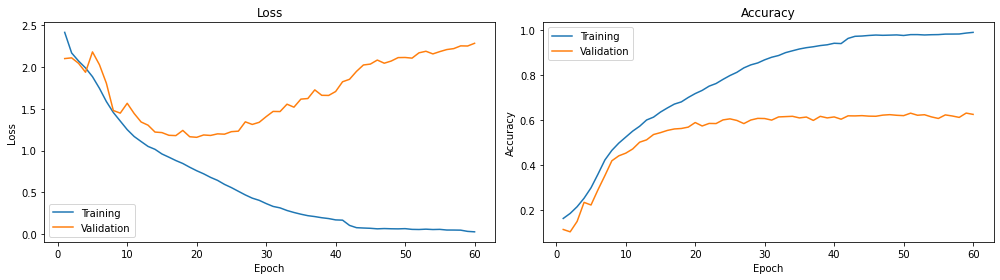

In [23]:
history = h0.history
for k in history.keys():
    history[k] += h1.history[k]

epoch_range = range(1, len(history['loss']) + 1)

plt.figure(figsize=[14,4])
plt.subplot(1, 2, 1)
plt.plot(epoch_range, history['loss'], label = 'Training')
plt.plot(epoch_range, history['val_loss'], label = 'Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epoch_range, history['accuracy'], label = 'Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
model.save('/content/drive/MyDrive/DeepLearningProject/EmotionDetection/model.h5')